# Daten

Funktionen:
- def process_files:  zum Verarbeiten aller Files
- def test_stationarity(data, variable_name): zum Testen der Stationarität eines dataframes -> Ausgabe: Liste mit Tupeln

## Daten importieren und mergen

In [2]:
#Daten zusammenfügen
import pandas as pd
import glob
import os
import pickle
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL
from scipy.stats import spearmanr
from scipy.fftpack import fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hampel import hampel
from scipy.stats import skew
from scipy.stats import skewtest
import joblib
from pandas.tseries.offsets import DateOffset
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression



# Verzeichnis mit den Dateien angeben
csv_files_all = "C:/Users/Lotta/OneDrive/Uni/Master/Masterarbeit Python 3.12/Daten/Daten CSV/*.csv"
dateien = glob.glob(csv_files_all)
    

# Initialisierung der Listen für die verschiedenen Dateitypen
daily_data, hourly_data, weekly_data, monthly_data = [], [], [], []
dfs_hourly, dfs_daily, dfs_weekly, dfs_monthly = [], [], [], []

#Betrachtungszeitraum festlegen
start_date = '2021-11-01'
end_date = '2024-10-01'

# Funktion zum Verarbeiten der Dateien
def process_files(file_list, date_type, dfs_list, split_date="2023-10-01"):
    for file in file_list:
        try:
            # Lese jede CSV-Datei ein
            df = pd.read_csv(file, encoding='ISO-8859-1', sep=';', header=0, dtype={'column': str}, low_memory=False)  # Passe Encoding und Separator an
            df.columns = df.columns.str.replace('ï»¿', '', regex=True)  # Entferne 'ï»¿' beim Datum
            # Überprüfe, ob eine Spalte 'Date' existiert
            if 'Date' in df.columns:
                # Versuche die 'Date'-Spalte in datetime zu konvertieren
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
                # Filtere die Daten basierend auf dem Betrachtungszeitraum
                df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
                # Lösche alle Spalten, die mit 'Unnamed' anfangen
                df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
                dfs_list.append(df)
            else:
                print(f"Die Datei {file} enthält keine 'Date'-Spalte und wird übersprungen.")
        except Exception as e:
            print(f"Fehler beim Verarbeiten der Datei {file}: {e}")

    # Kombiniere alle DataFrames basierend auf der 'Date'-Spalte
    if dfs_list:
        merged_df = pd.concat(dfs_list, ignore_index=True).sort_values(by='Date')
        merged_df = merged_df.groupby('Date', as_index=False).first()
        train_df = merged_df[merged_df['Date'] < split_date]
        test_df = merged_df[merged_df['Date'] >= split_date]

        return train_df, test_df
    else:
        print(f"Keine gültigen '{date_type}'-Daten gefunden.")
        return None

# Zuordnung der Dateien basierend auf ihrem Namen
for file in dateien:
    if 'daily' in os.path.basename(file):
        daily_data.append(file)
    elif 'hourly' in os.path.basename(file):
        hourly_data.append(file)
    elif 'weekly' in os.path.basename(file):
        weekly_data.append(file)
    elif 'monthly' in os.path.basename(file):
        monthly_data.append(file)

# Verarbeite jede Datengruppe und kombiniere die DataFrames
# Verarbeite jede Datengruppe mit Train/Test-Split
train_hourly, test_hourly = process_files(hourly_data, 'hourly', dfs_hourly)
train_daily, test_daily = process_files(daily_data, 'daily', dfs_daily)
train_weekly, test_weekly = process_files(weekly_data, 'weekly', dfs_weekly)
train_monthly, test_monthly = process_files(monthly_data, 'monthly', dfs_monthly)

# Zusammenfassen der Ergebnisse
train_dfs = [train_hourly, train_daily, train_weekly, train_monthly]
test_dfs = [test_hourly, test_daily, test_weekly, test_monthly]
with open('test_dfs.pkl', 'wb') as f:
    pickle.dump(test_dfs, f)

C:\Users\Lotta\AppData\Local\Temp\ipykernel_5428\190126636.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
C:\Users\Lotta\AppData\Local\Temp\ipykernel_5428\190126636.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)


## Daten up and downsampeln

###Allgemein
- cubic interpolation for weekly data
- median resampling for hourly data 
- cubic interpolation for monthly data 
    - divide summed value by index.days and interpolate afterwards

###Others
- fill NaN values for US LNG to Germany with 0

In [3]:

#Upsampling


#Interpolieren der Daten
for df in train_dfs: 
    if 'Date' in df.columns:
        df.set_index('Date', inplace=True) # Setze die 'Date'-Spalte als Index
    else:
        print(f"'Date' column not found in dataframe with columns: {df.columns}")

# Resample auf tägliche Daten und Interpolation der numerischen Spalten
daily_df_from_weekly = train_weekly.resample('D').interpolate(method= 'cubic')
daily_from_hourly = train_hourly.resample ('D').median()

start_interpolation_date = '2022-11-01'
# NaN-Werte in der Spalte US LNG to Germany mit 0 auffüllen
train_monthly['A-US LNG to Germany'] = train_monthly['A-US LNG to Germany'].fillna(0)   
# Resample die Daten auf täglich und führe eine Interpolation mit cubic durch
for  col in train_monthly:
    if col.startswith('A'):
        train_monthly[col] = train_monthly[col].div(train_monthly.index.days_in_month, axis=0).round(3)
        
daily_from_monthly = train_monthly.resample('D').interpolate(method='cubic')   
# Setze alle Werte bis zum Startdatum der Interpolation auf 0 im daily_from_monthly DataFrame
daily_from_monthly.loc[:start_interpolation_date, 'A-US LNG to Germany'] = 0
all_daily_dfs = [daily_df_from_weekly, daily_from_hourly, daily_from_monthly, train_daily]


#combine all daily data frames
train_final_df = pd.concat(all_daily_dfs, axis=1)
train_final_df.index = pd.to_datetime(train_final_df.index)

train_final_df = train_final_df.loc[:, ~train_final_df.columns.str.startswith('Unnamed')]
#Lag von 1 Tag einbaune, da gestrige Daten die neusten Daten sind, die vorliegen
columns_to_lag_one = [col for col in train_final_df.columns if col != 'S-Gas DA NL']

# Daten um einen Tag verschieben (Lag)
train_final_df[columns_to_lag_one] = train_final_df[columns_to_lag_one].shift(1)


# train_final_df auf drei Nachkommastellen runden
train_final_df = train_final_df.round(3)

### Up- und downgesampelte Daten plotten
Optional

In [4]:
"""# Diagramm für wöchentliche Daten
plt.figure(figsize=(15, 6))

# Plot für jede numerische Spalte in daily_df_from_weekly
for column in daily_df_from_weekly.columns:
    plt.plot(daily_df_from_weekly.index, daily_df_from_weekly[column], label=f'Daily Interpolated {column}', linestyle='-', marker='')

# Plot für jede numerische Spalte in merged_df_weekly
for column in merged_df_weekly.columns:
    plt.plot(merged_df_weekly.index, merged_df_weekly[column], label=f'Weekly Data {column}', linestyle='--', marker='o')

# Diagramm beschriften
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Weekly Data vs. Daily Interpolated Data')
plt.legend()
plt.grid(True)

    # Diagramm anzeigen
plt.show()
    # Plot für jede numerische Spalte in daily_df_from_hourly

#Diagramm für stündliche Daten
plt.figure(figsize=(15, 6))
for column in daily_from_hourly.columns:
    plt.plot(daily_from_hourly.index, daily_from_hourly[column], label=f'Daily Interpolated {column}', linestyle='-', marker='')
# Plot für jede numerische Spalte in merged_df_hourly
for column in merged_df_hourly.columns:
    plt.plot(merged_df_hourly.index, merged_df_hourly[column], label=f'Hourly Data {column}', linestyle='--', marker='o')

# Legende, Achsentitel und Anzeige des Plots
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.title("Vergleich: Daily Interpolated vs. Hourly Data")
plt.legend()
plt.grid(True)
plt.show()"""

"""#alle monatlichen in getrennten plots plotten
num_columns = len(daily_from_monthly.columns)  # Anzahl der Spalten
fig, axes = plt.subplots(num_columns, 1, figsize=(15, 6 * num_columns))

# Wenn es nur eine Spalte gibt, sorgt dieser Code dafür, dass axes eine einzelne Achse ist
if num_columns == 1:
    axes = [axes]

# Gehe jede Spalte durch und erstelle ein Diagramm
for i, column in enumerate(daily_from_monthly.columns):
    # Daily Interpolated plot
    axes[i].plot(daily_from_monthly.index, daily_from_monthly[column], label=f'Daily Interpolated {column}', linestyle='-', marker='')

    # Monthly Data plot
    axes[i].plot(merged_df_monthly.index, merged_df_monthly[column], label=f'Monthly Data {column}', linestyle='--', marker='o')

    # Achsenbeschriftungen und Titel
    axes[i].set_xlabel("Datum")
    axes[i].set_ylabel("Wert")
    axes[i].set_title(f"Vergleich: Daily Interpolated vs. Monthly Data ({column})")
    axes[i].legend()
    axes[i].grid(True)

# Layout anpassen, um Überschneidungen zu vermeiden
plt.tight_layout()
plt.show()"""



'#alle monatlichen in getrennten plots plotten\nnum_columns = len(daily_from_monthly.columns)  # Anzahl der Spalten\nfig, axes = plt.subplots(num_columns, 1, figsize=(15, 6 * num_columns))\n\n# Wenn es nur eine Spalte gibt, sorgt dieser Code dafür, dass axes eine einzelne Achse ist\nif num_columns == 1:\n    axes = [axes]\n\n# Gehe jede Spalte durch und erstelle ein Diagramm\nfor i, column in enumerate(daily_from_monthly.columns):\n    # Daily Interpolated plot\n    axes[i].plot(daily_from_monthly.index, daily_from_monthly[column], label=f\'Daily Interpolated {column}\', linestyle=\'-\', marker=\'\')\n\n    # Monthly Data plot\n    axes[i].plot(merged_df_monthly.index, merged_df_monthly[column], label=f\'Monthly Data {column}\', linestyle=\'--\', marker=\'o\')\n\n    # Achsenbeschriftungen und Titel\n    axes[i].set_xlabel("Datum")\n    axes[i].set_ylabel("Wert")\n    axes[i].set_title(f"Vergleich: Daily Interpolated vs. Monthly Data ({column})")\n    axes[i].legend()\n    axes[i].grid

## 1. Data Preprocessing

### 1.1 Data Anomalies - Outliers and Missing values

#### Outliers
- drop all weekend data
- convert UnPlanned Unavailability into binary format
- check whether data frame only hold numerical values
- drop all columns that do not differ from others besides unit
- insert new columns with sum of US export terminals

In [5]:
# Tage extrahieren
train_final_df['Day'] = train_final_df.index.weekday+1

train_final_df = train_final_df[~train_final_df['Day'].isin([6,7])]
train_final_df = train_final_df.drop(columns=['Day'])


train_final_df['A- UnPlanned Unavailability Norway'] = (train_final_df['A- UnPlanned Unavailability Norway'] == 'Unplanned').astype(int)


#Check whether the data frame only hold numerical values
for column in train_final_df:
    if train_final_df[column].dtype == 'object':
        print(train_final_df[column].name)
        
## First Feature Selection
train_final_df =train_final_df.drop(columns=['A-Annual Consumption (TWh)', 'A- Gas stprage Technical Capacity (TWh)', 'A-Injection capacity (GWh/d)','N-Withdrawal capacity (GWh/d)','A-LNG Inventory (10³ ? LNG)', 'A-Technical Capacity / DTMI (10³ ? LNG)']) 


# Neue Spalte zu Exportterminals LNG in USA hinzufügen
lng_columns = [col for col in train_final_df.columns if col.startswith('A-LNG US')]
train_final_df['A-US LNG Exportterminals'] = train_final_df[lng_columns].sum(axis=1).round(3)

# Lösche die ursprünglichen 'A-LNG US'-Spalten
train_final_df.drop(columns=lng_columns, inplace=True)

#### Handle missing values 
- delete all coumns with missing values > 40%
- interpolate single misisng values linear
- unify units 

In [6]:
## Handling missing values
# Alle missing values behandeln, die nicht interpoliert werden können
train_final_df = train_final_df.loc[:, train_final_df.isnull().mean() < 0.4] #Lösche Spalten mit missing values > 40%
train_final_df = train_final_df.interpolate(method='linear')
train_final_df = train_final_df.bfill()
train_final_df = train_final_df.dropna()
#Check whether there are missing values
for col in train_final_df.columns:
    numberNA = train_final_df[col].isna().sum()
    if numberNA > 0:
        print(f"Column {col} has {numberNA} missing values.")

## Daten umrechnen & runden
train_final_df['A-Gas in storage (TWh)'] = train_final_df['A-Gas in storage (TWh)'].mul(1000)#Twh zu Gwh
train_final_df['A-US LNG to Germany'] = train_final_df['A-US LNG to Germany'].mul(0.2931) #MMcf zu GWh
train_final_df['A-US LNG Exportterminals'] = train_final_df['A-US LNG Exportterminals'].mul(293.1) #Bcf zu GWh
train_final_df['A-Norway Exit Nomination'] = train_final_df['A-Norway Exit Nomination'].mul(11.55) # 10³ m³/d zu GWh/d
train_final_df['A-Importiertes Erdgas Deutschland'] = train_final_df['A-Importiertes Erdgas Deutschland'].mul(0.2778) # Terajoule in GWh
train_final_df['S-Power price'] = train_final_df['S-Power price'].mul(10) # ct/KWh in €/MWh
train_final_df = train_final_df.round(3)

train_y_final = train_final_df[['S-Gas DA NL']]
train_final_df = train_final_df.drop(columns=['S-Gas DA NL'])

## EDA

### univariat 
- descriptive statistic
- liniendiagramm für alle 

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_line_charts(df, save_folder, name):
    num_vars = len(df.columns)
    cols = 5
    rows = (num_vars // cols) + int(num_vars % cols > 0)
    
    plt.figure(figsize=(cols*4, rows*3))
    for i, col in enumerate(df.columns):
        plt.subplot(rows, cols, i+1)
        plt.plot(df.index, df[col], color='#83CBEB')
        plt.title(col, fontsize=8)
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    os.makedirs(save_folder, exist_ok=True)
    filename = os.path.join(save_folder, f"{name}.png")
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Saved line plots to {filename}")

def plot_histograms(df, save_folder, name):
    num_vars = len(df.columns)
    cols = 5
    rows = (num_vars // cols) + int(num_vars % cols > 0)
    
    plt.figure(figsize=(cols*4, rows*3))
    for i, col in enumerate(df.columns):
        plt.subplot(rows, cols, i+1)
        sns.histplot(df[col].dropna(), kde=True, color='#84E291')
        plt.title(col, fontsize=8)
        plt.tight_layout()
    
    os.makedirs(save_folder, exist_ok=True)
    filename = os.path.join(save_folder, f"{name}.png")
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Saved histograms to {filename}")

def save_descriptive_stats(df, save_folder, name):
    desc_stats = df.describe().T
    os.makedirs(save_folder, exist_ok=True)
    filename = os.path.join(save_folder, f"{name}.csv")
    desc_stats.to_csv(filename)
    print(f"Saved descriptive statistics to {filename}")


# Beispielaufruf:
save_folder = r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA"

# train_final_df als DataFrame mit 55 Variablen, Index sollte Zeit sein (Datum o.Ä.)
plot_line_charts(train_final_df, save_folder, "univariat_linechart_all")
plot_histograms(train_final_df, save_folder, "univariat_histogram_all")
save_descriptive_stats(train_final_df, save_folder, "univariat_destriptive_statistics_all")
plot_line_charts(train_y_final, save_folder, "univariat_linechart_target")
plot_histograms(train_y_final, save_folder, "univariat_histogram_target")
save_descriptive_stats(train_y_final, save_folder, "univariat_destriptive_statistics_target")

Saved line plots to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\univariat_linechart_all.png
Saved histograms to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\univariat_histogram_all.png
Saved descriptive statistics to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\univariat_destriptive_statistics_all.csv
Saved line plots to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\univariat_linechart_target.png
Saved histograms to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\univariat_histogram_target.png
Saved descriptive statistics to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\univariat_destriptive_statistics_target.csv


In [ ]:
import importlib.metadata as m

print("interpret:", m.version("interpret"))
print("scikit-learn:", m.version("scikit-learn"))
print("xgboost:", m.version("xgboost"))
print("igann:", m.version("igann"))
print("prophet:", m.version("prophet"))  # oder 'fbprophet', wenn alt
print("pygam:", m.version("pygam"))


interpret: 0.6.10
scikit-learn: 1.6.1
xgboost: 3.0.0
igann: 0.1.7
prophet: 1.1.6
pygam: 0.9.1


In [ ]:
import importlib.metadata as m

print("interpret:", m.version("interpret"))
print("scikit-learn:", m.version("scikit-learn"))
print("xgboost:", m.version("xgboost"))
print("igann:", m.version("igann"))
print("prophet:", m.version("prophet"))  # oder 'fbprophet', wenn alt
print("pygam:", m.version("pygam"))


interpret: 0.6.10
scikit-learn: 1.6.1
xgboost: 3.0.0
igann: 0.1.7
prophet: 1.1.6
pygam: 0.9.1


### bivariat
- Scatterplots

In [21]:
import os
import matplotlib.pyplot as plt

def plot_scatter_lag0(df, target_column, 
                      save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA",
                      figsize_per_plot=(4, 3)):
    
    features = [col for col in df.columns if col != target_column]
    os.makedirs(save_folder, exist_ok=True)

    plt.figure(figsize=(figsize_per_plot[0]*6, figsize_per_plot[1]*10))  # 6 Spalten × 10 Reihen
    plt.suptitle(f'Scatterplots {target_column} vs. Features (lag=0)', fontsize=18)
    colors = ['#84E291', '#83CBEB', '#E59EDD']

    for i, feature in enumerate(features, 1):
        plt.subplot(10, 6, i)
        x = df[feature]
        y = df[target_column]
        valid = x.notna() & y.notna()
        color = colors[(i - 1) % len(colors)]

        plt.scatter(x[valid], y[valid], alpha=0.4, s=10, color=color)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel(target_column, fontsize=10)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    filename = os.path.join(save_folder, "scatter_lag_0.png")
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Saved plot to {filename}")

df = train_final_df.copy()
df['target'] = train_y_final.iloc[:, 0]
plot_scatter_lag0(df, 'target')


Saved plot to C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\scatter_lag_0.png


In [23]:
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#E59EDD', '#83CBEB', '#84E291'], N=256)

#Correlation with target 
def plot_and_save_target_correlations(df, target_df, target_column, save_folder):
    os.makedirs(save_folder, exist_ok=True)

    # Zielvariable als Series
    target_series = target_df[target_column]

    # DataFrame für Korrelationen vorbereiten
    corr_spearman = {}
    corr_kendall = {}

    for col in df.columns:
        corr_spearman[col] = df[col].corr(target_series, method='spearman')
        corr_kendall[col] = df[col].corr(target_series, method='kendall')

    # In DataFrames umwandeln (1 Spalte = Zielvariable)
    corr_spearman_df = pd.DataFrame.from_dict(corr_spearman, orient='index', columns=[target_column])
    corr_kendall_df = pd.DataFrame.from_dict(corr_kendall, orient='index', columns=[target_column])

    # Heatmap: Spearman
    plt.figure(figsize=(8, len(df.columns)*0.4 + 2))
    sns.heatmap(corr_spearman_df, annot=True, cmap=custom_cmap, center=0)
    plt.title(f"Spearman Correlation with {target_column}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_folder, "correlation_spearman_target.png"), dpi=300)
    plt.close()

    # Heatmap: Kendall
    """plt.figure(figsize=(4, len(df.columns)*0.25 + 2))
    sns.heatmap(corr_kendall_df, annot=True, cmap=custom_cmap, center=0)
    plt.title(f"Kendall Correlation with {target_column}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_folder, "correlation_kendall_target.png"), dpi=300)
    plt.close()"""

    # Korrelationen als CSV speichern
    corr_spearman_df.to_csv(os.path.join(save_folder, "correlation_spearman_target.csv"))
   # corr_kendall_df.to_csv(os.path.join(save_folder, "correlation_kendall_target.csv"))

    print("Korrelationen zur Zielvariable gespeichert als Heatmap und CSV.")

# Beispielaufruf:
plot_and_save_target_correlations(
    df=train_final_df,
    target_df=train_y_final,
    target_column="S-Gas DA NL",  # <- hier deine Zielspalte einsetzen
    save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA"
)


Korrelationen zur Zielvariable gespeichert als Heatmap und CSV.


### multivariat


In [ ]:
def plot_and_filter_high_spearman_correlations(df, save_folder, threshold=0.9):
    os.makedirs(save_folder, exist_ok=True)

    # Spearman-Korrelationsmatrix
    spearman_corr = df.corr(method='spearman')

    # Heatmap speichern
    plt.figure(figsize=(15, 12))
    sns.heatmap(spearman_corr, cmap=custom_cmap, annot=False, center=0)
    plt.title("Spearman Correlation")
    plt.tight_layout()
    plt.savefig(os.path.join(save_folder, "correlation_spearman.png"), dpi=300)
    plt.close()

    print("Spearman-Korrelations-Heatmap gespeichert.")

    # Liste stark korrelierter Merkmale erstellen
    high_corr_pairs = []
    for i in range(len(spearman_corr.columns)):
        for j in range(i + 1, len(spearman_corr.columns)):
            if abs(spearman_corr.iloc[i, j]) > threshold:
                col1 = spearman_corr.columns[i]
                col2 = spearman_corr.columns[j]
                high_corr_pairs.append((col1, col2))

    print("Stark korrelierte Merkmale (>|0.9|):")
    for pair in high_corr_pairs:
        print(pair)

    return high_corr_pairs

# Beispielaufruf
high_corr_features = plot_and_filter_high_spearman_correlations(
    df=train_final_df,
    save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA"
)


Spearman-Korrelations-Heatmap gespeichert.
Stark korrelierte Merkmale (>|0.9|):
('S-Coal Price (close)', 'S-Coal Channel (Max)')
('S-Coal Price (close)', 'S-Coal Channel (Min)')
('S-Coal Price (close)', 'S-Coal Switching Price Average')
('A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)', 'N&P-Geschaeftslage (verarbeitendes Gewerbe)')
('N&P-Geschaeftsklima (Deutschland)', 'N&P-Geschaeftserwartungen (Deutschland)')
('N&P-Geschaeftsklima (verarbeitendes Gewerbe)', 'N&P-Geschaeftslage (verarbeitendes Gewerbe)')
('N&P-Geschaeftsklima (verarbeitendes Gewerbe)', 'N&P-Geschaeftserwartungen (verarbeitendes Gewerbe)')
('P-European_News_Index', 'P-Germany_News_Index')
('A-Gas in storage (TWh)', 'A-Gas storage Full (%)')
('A-Gas in storage (TWh)', 'A-Stock/Cons (%)')
('A-Gas storage Full (%)', 'A-Stock/Cons (%)')
('A-gas storage Trend (%)', 'A-Gas Injection (GWh/d)')
('A-LNG Inventory (~GWh)', 'A-Technical Capacity / DTMI (~GWh)')
('A-LNG Inventory (~GWh)', 'A-Send-O

C:\Users\Lotta\AppData\Local\Temp\ipykernel_5428\4197281319.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Korrelationen zur Zielvariable gespeichert als Heatmap und CSV.


### ACF und PACF für self lags


Analysiere Feature: S-Coal Price (close)
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1, 2, 3, 4, 5]

Analysiere Feature: K-Wind speed
Signifikante ACF Lags: [1, 2, 3]
Signifikante PACF Lags: [1]

Analysiere Feature: S-Power price
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1, 2, 3, 4, 5]

Analysiere Feature: A-Flow Norway to Continent (excl UK)
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1]

Analysiere Feature: A-Flow Norway to UK
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1, 2, 3]

Analysiere Feature: A-Flow Russian Three Main Lines
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1, 3]

Analysiere Feature: A-Flow Russia to Bulgaria (TurkStream 2)
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1, 2, 3, 4, 5]

Analysiere Feature: A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)
Signifikante ACF Lags: [1, 2, 3, 4, 5]
Signifikante PACF Lags: [1, 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lotta\\OneDrive\\Uni\\Master\\Masterarbeit Text\\Bilder\\EDA\\acf_pacf_A-Stock/Cons (%).png'

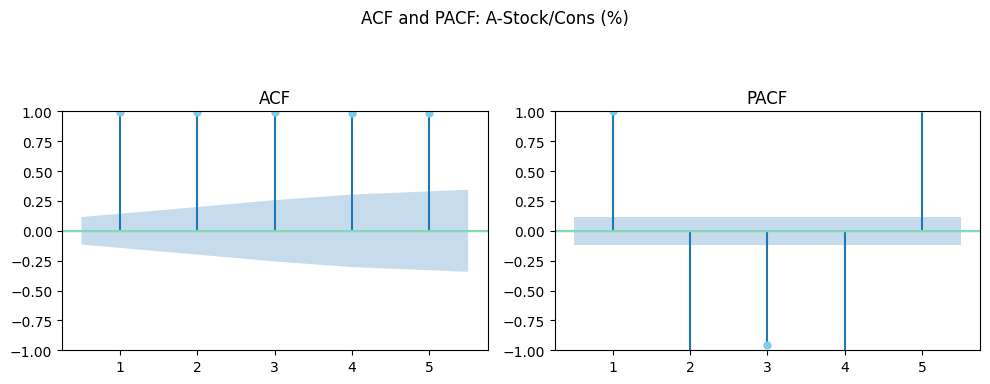

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Farbdefinitionen
acf_color = '#83CBEB'
confint_color = '#E59EDD'
zero_line_color = '#84E291'

def get_significant_lags(series, nlags=20, alpha=0.05):
    acf_vals, confint_acf = acf(series, nlags=nlags, alpha=alpha)
    pacf_vals, confint_pacf = pacf(series, nlags=nlags, alpha=alpha, method='yw')

    acf_significant_lags = []
    pacf_significant_lags = []

    for i in range(1, nlags + 1):
        if (confint_acf[i, 0] > 0) or (confint_acf[i, 1] < 0):
            acf_significant_lags.append(i)
        if (confint_pacf[i, 0] > 0) or (confint_pacf[i, 1] < 0):
            pacf_significant_lags.append(i)

    return {'acf': acf_significant_lags, 'pacf': pacf_significant_lags}

def analyze_all_features_lags(df, nlags=20, alpha=0.05, save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA"):
    lags_dict = {}
    os.makedirs(save_folder, exist_ok=True)

    for col in df.columns:
        print(f"\nAnalysiere Feature: {col}")
        series = df[col].dropna()

        lags = get_significant_lags(series, nlags=nlags, alpha=alpha)
        lags_dict[col] = lags

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(f"ACF and PACF: {col}", fontsize=12)

        # ACF
        plot_acf(series, lags=nlags, alpha=alpha, zero=False, ax=axes[0])
        axes[0].set_title("ACF")
        for line in axes[0].lines:
            line.set_color(acf_color if line.get_linestyle() != '--' else confint_color)
        axes[0].axhline(0, color=zero_line_color, lw=1)

        # PACF
        plot_pacf(series, lags=nlags, alpha=alpha, zero=False, ax=axes[1], method='yw')
        axes[1].set_title("PACF")
        for line in axes[1].lines:
            line.set_color(acf_color if line.get_linestyle() != '--' else confint_color)
        axes[1].axhline(0, color=zero_line_color, lw=1)

        plt.tight_layout(rect=[0, 0.03, 1, 0.90])
        filename = os.path.join(save_folder, f"acf_pacf_{col}.png")
        plt.savefig(filename, dpi=300)
        plt.close()

        print(f"Signifikante ACF Lags: {lags['acf']}")
        print(f"Signifikante PACF Lags: {lags['pacf']}")

    # Speichern der Lags als CSV
    lag_csv_path = os.path.join(save_folder, "significant_lags.csv")
    pd.DataFrame({
        col: {
            "acf_lags": ','.join(map(str, lags_dict[col]['acf'])),
            "pacf_lags": ','.join(map(str, lags_dict[col]['pacf']))
        } for col in lags_dict
    }).T.to_csv(lag_csv_path)

    return lags_dict

# Beispielaufruf:
lags_per_feature = analyze_all_features_lags(
    train_final_df,
    nlags=5,
    alpha=0.01,
    save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA"
)


### STL for thesis


STL-Zerlegung: S-Coal Price (close)
STL-Zerlegung: K-Wind speed
STL-Zerlegung: S-Power price
STL-Zerlegung: A-Flow Norway to Continent (excl UK)
STL-Zerlegung: A-Flow Norway to UK
STL-Zerlegung: A-Flow Russian Three Main Lines
STL-Zerlegung: A-Flow Russia to Bulgaria (TurkStream 2)
STL-Zerlegung: A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)
STL-Zerlegung: A-Flow Russia to Hungary (Net VIP Bereg)
STL-Zerlegung: A-Flow North African Piped
STL-Zerlegung: A-Flow UK LNG Sendout
STL-Zerlegung: A-Flow Continental LNG Sendout 
STL-Zerlegung: A-Flow Azerbaijan via TAP to Italy
STL-Zerlegung: A-US LNG to Germany
STL-Zerlegung: A-Importiertes Erdgas Deutschland
STL-Zerlegung: N&P-Geschaeftsklima (Deutschland)
STL-Zerlegung: N&P-Geschaeftslage (Deutschland)
STL-Zerlegung: N&P-Geschaeftserwartungen (Deutschland)
STL-Zerlegung: N&P-Geschaeftsklima (verarbeitendes Gewerbe)
STL-Zerlegung: N&P-Geschaeftslage (verarbeitendes Gewerbe)
STL-Zerlegung: N&P-Geschaeftserwartu

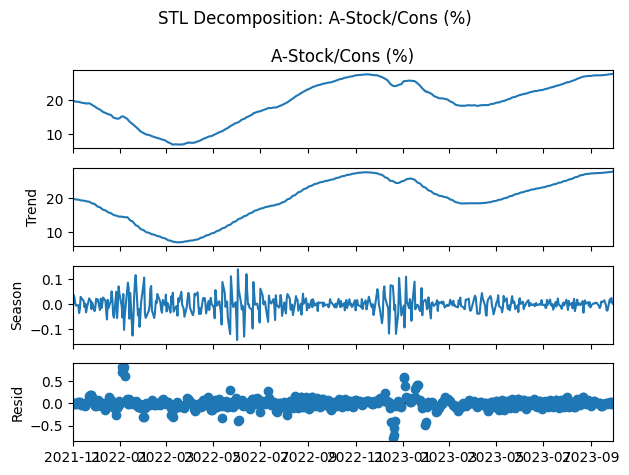

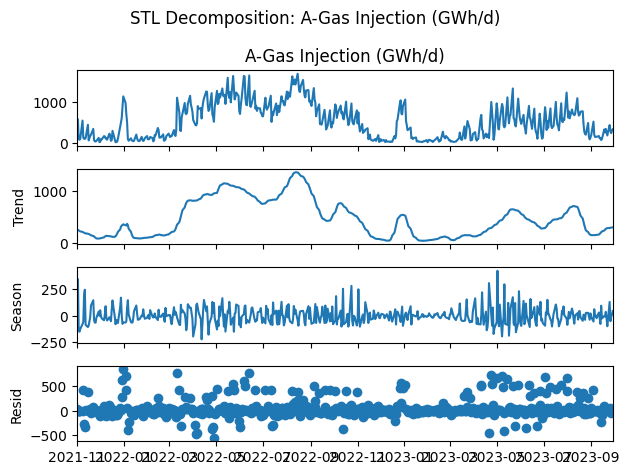

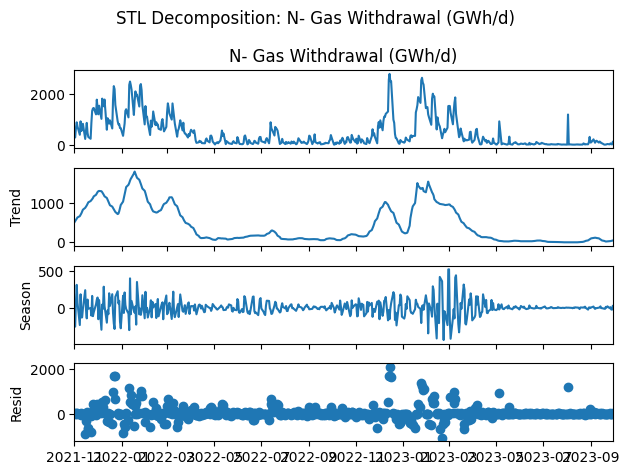

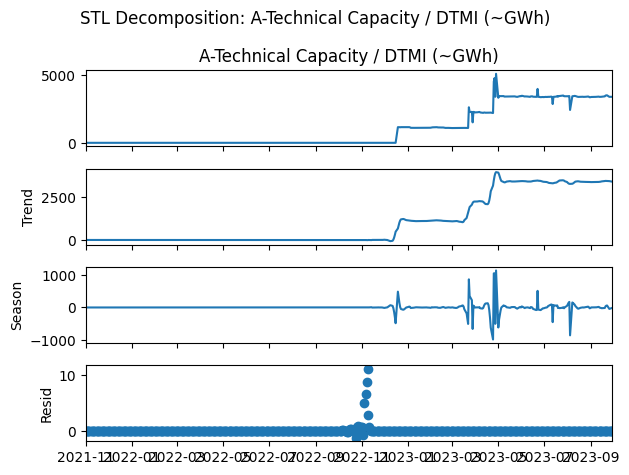

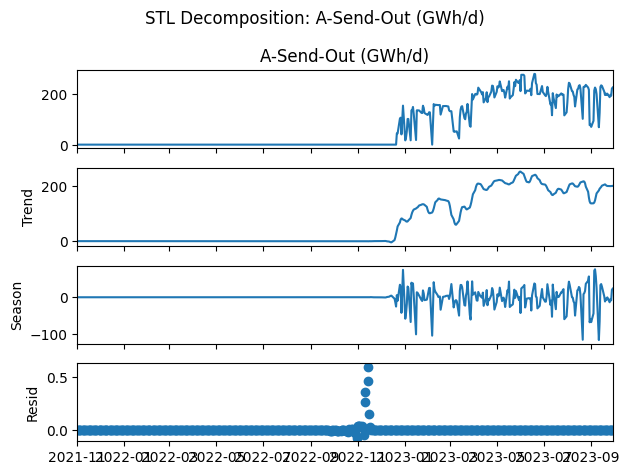

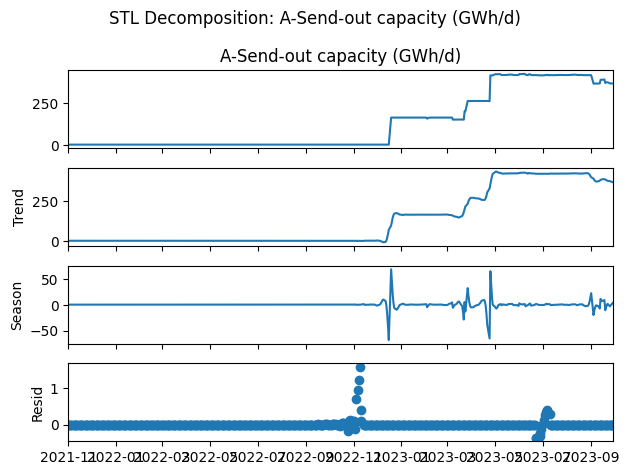

In [15]:
from statsmodels.tsa.seasonal import STL

def decompose_all_features_stl(df, period, save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\STL"):
    os.makedirs(save_folder, exist_ok=True)

    for col in df.columns:
        print(f"STL-Zerlegung: {col}")
        series = df[col].dropna()

        try:
            stl = STL(series, period=period, robust=True)
            result = stl.fit()

            fig = result.plot()
            fig.suptitle(f"STL Decomposition: {col}", fontsize=12)
            plt.tight_layout()
            filename = os.path.join(save_folder, f"stl_{col}.png")
            plt.savefig(filename, dpi=300)
            plt.close()
        except Exception as e:
            print(f"Fehler bei {col}: {e}")

decompose_all_features_stl(
    df=train_final_df,
    period=7,  # z. B. für wöchentliche Saisonalität bei Tagesdaten
    save_folder=r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\STL"
)



In [20]:


# Einstellungen
variable = "A-Importiertes Erdgas Deutschland"
save_path = r"C:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Text\Bilder\EDA\STL\stl_A_Importiertes_Erdgas_Deutschland260.png"
stl_color = '#83CBEB'
period = 260  # ggf. anpassen: z. B. 7 = wöchentlich bei Tagesdaten

# Daten vorbereiten (Beispiel: train_final_df muss enthalten sein)
series = train_final_df[variable].dropna()

# STL-Zerlegung
stl = STL(series, period=period, robust=True)
result = stl.fit()

# Plot erstellen
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
fig.suptitle(f"STL Decomposition: {variable}", fontsize=14)

components = {
    "Original": series,
    "Trend": result.trend,
    "Season": result.seasonal,
    "Resid": result.resid
}

for ax, (title, data) in zip(axes, components.items()):
    ax.plot(data.index, data.values, color=stl_color)
    ax.set_ylabel(title)
    ax.grid(True)

axes[-1].set_xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Speichern
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.close()


In [ ]:
from scipy.stats import spearmanr

def debug_spearman_lags(df, target_series, max_lag=5):
    debug_info = {}
    for feature in df.columns:
        lag_results = []
        for lag in range(1, max_lag + 1):
            lagged = df[feature].shift(lag)
            # Gemeinsame Indizes nehmen (dropna in beiden)
            valid_idx = lagged.dropna().index.intersection(target_series.dropna().index)
            if len(valid_idx) == 0:
                corr = None
                pval = None
            else:
                corr, pval = spearmanr(lagged.loc[valid_idx], target_series.loc[valid_idx])
            lag_results.append({'lag': lag, 'corr': corr, 'pval': pval})
        debug_info[feature] = lag_results

    # Ausgabe (kannst du auch abspeichern)
    for feature, results in debug_info.items():
        print(f"\nFeature: {feature}")
        for res in results:
            print(f"  Lag {res['lag']}: Spearman corr = {res['corr']:.4f}  p-value = {res['pval']:.4g}")
    return debug_info

# Beispiel-Aufruf:
debug_spearman_lags(train_final_df, train_y_final, max_lag=5)



Feature: S-Coal Price (close)
  Lag 1: Spearman corr = 0.8128  p-value = 1.005e-118
  Lag 2: Spearman corr = 0.8073  p-value = 1.102e-115
  Lag 3: Spearman corr = 0.8023  p-value = 5.583e-113
  Lag 4: Spearman corr = 0.7977  p-value = 1.394e-110
  Lag 5: Spearman corr = 0.7927  p-value = 4.971e-108

Feature: K-Wind speed
  Lag 1: Spearman corr = -0.0625  p-value = 0.1633
  Lag 2: Spearman corr = -0.0678  p-value = 0.1306
  Lag 3: Spearman corr = -0.0645  p-value = 0.1513
  Lag 4: Spearman corr = -0.0651  p-value = 0.1479
  Lag 5: Spearman corr = -0.0670  p-value = 0.1369

Feature: S-Power price
  Lag 1: Spearman corr = 0.7663  p-value = 1.566e-97
  Lag 2: Spearman corr = 0.7549  p-value = 6.511e-93
  Lag 3: Spearman corr = 0.7425  p-value = 3.434e-88
  Lag 4: Spearman corr = 0.7348  p-value = 2.573e-85
  Lag 5: Spearman corr = 0.7263  p-value = 2.754e-82

Feature: A-Flow Norway to Continent (excl UK)
  Lag 1: Spearman corr = 0.1621  p-value = 0.0002761
  Lag 2: Spearman corr = 0.1618 

{'S-Coal Price (close)': [{'lag': 1,
   'corr': 0.8128175453732019,
   'pval': 1.0045790433130362e-118},
  {'lag': 2, 'corr': 0.8072968897505154, 'pval': 1.1020522313080743e-115},
  {'lag': 3, 'corr': 0.8022619876553646, 'pval': 5.583043168250805e-113},
  {'lag': 4, 'corr': 0.7977091537267447, 'pval': 1.394252857290219e-110},
  {'lag': 5, 'corr': 0.7926794461625649, 'pval': 4.9707706702320256e-108}],
 'K-Wind speed': [{'lag': 1,
   'corr': -0.0625016946883818,
   'pval': 0.1633043665116301},
  {'lag': 2, 'corr': -0.06783291796607566, 'pval': 0.13061245649791636},
  {'lag': 3, 'corr': -0.06446737020906845, 'pval': 0.1512650574509943},
  {'lag': 4, 'corr': -0.06506529623696211, 'pval': 0.1479108219089386},
  {'lag': 5, 'corr': -0.06695349897852315, 'pval': 0.13687626075203657}],
 'S-Power price': [{'lag': 1,
   'corr': 0.76625265148403,
   'pval': 1.565821647131287e-97},
  {'lag': 2, 'corr': 0.754882875385975, 'pval': 6.511015206733209e-93},
  {'lag': 3, 'corr': 0.7425137299004244, 'pval

In [ ]:
from scipy.stats import spearmanr

def get_significant_spearman_lags(df, target_series, max_lag=5, corr_threshold=0.3, alpha=0.05):
    spearman_lags = {}
    for feature in df.columns:
        lags = []
        for lag in range(1, max_lag + 1):
            lagged = df[feature].shift(lag)
            common_index = target_series.index.intersection(lagged.dropna().index)
            if len(common_index) == 0:
                continue
            x = lagged.loc[common_index]
            y = target_series.loc[common_index]
            corr, pval = spearmanr(x, y)
            if abs(corr) >= corr_threshold and pval < alpha:
                lags.append(lag)
        spearman_lags[feature] = lags
    return spearman_lags

def combine_lags(pacf_results, spearman_results):
    combined_lags = {}
    all_features = set(pacf_results.keys()) | set(spearman_results.keys())
    for feature in all_features:
        lags_pacf = pacf_results.get(feature, [])
        lags_spearman = spearman_results.get(feature, [])
        combined = sorted(set(lags_pacf) | set(lags_spearman))
        combined_lags[feature] = combined
    return combined_lags

def create_lagged_features(df, lags_dict):
    df_lagged = df.copy()
    for feature, lags in lags_dict.items():
        for lag in lags:
            df_lagged[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df_lagged

# Beispielaufruf
pacf_results = {feature: lags['pacf'] for feature, lags in lags_per_feature.items()}
spearman_results = get_significant_spearman_lags(train_final_df, train_y_final, max_lag=5, corr_threshold=0.3, alpha=0.05)
combined_lags = combine_lags(pacf_results, spearman_results)
final_df_with_lags = create_lagged_features(train_final_df, combined_lags)


NameError: name 'lags_per_feature' is not defined

## Feature Selection

### Test: Granger und Cross Corr 

In [ ]:

from statsmodels.tsa.stattools import grangercausalitytests
train_final_df_2023 = train_final_df[train_final_df.index > '2023-03-01']
train_y_final_2023 = train_y_final[train_y_final.index > '2023-03-01']
target_columns = train_y_final_2023['S-Gas DA NL']
# Cross-Korrelation
def cross_correlation(train_final_df_2023, train_y_final_2023, target_column, threshold=0.5):
    correlation_results = {}
    selected_features_cross = []
    
    # Berechnung der Cross-Korrelationen
    for col in train_final_df_2023.columns:
        correlation = train_final_df_2023[col].corr(train_y_final_2023[target_column])
        correlation_results[col] = correlation
        
        # Wenn die Korrelation über dem Schwellwert liegt, füge es zu den ausgewählten Features hinzu
        if abs(correlation) >= threshold:
            selected_features_cross.append(col)
    
    return correlation_results, selected_features_cross

# Granger-Kausalität
def granger_causality(train_final_df_2023, train_y_final_2023, target_column, max_lag=5, significance_level=0.05):
    granger_results = {}
    selected_features_granger = []
    
    # Berechnung der Granger-Kausalität
    for col in train_final_df_2023.columns:
        # Kombinieren der Zielvariable (Gaspreis) und der aktuellen Variablen für den Test
        data = pd.concat([train_final_df_2023[col], train_y_final_2023[target_column]], axis=1)
        data.columns = [col, target_column]
        
        # Granger-Kausalitätstest durchführen
        test_result = grangercausalitytests(data, max_lag, verbose=False)
        
        # Extrahieren des p-Werts für jeden Lag
        p_values = {}
        significant = False
        for lag in range(1, max_lag+1):
            p_values[lag] = test_result[lag][0]['ssr_chi2test'][1]  # p-Wert des Chi-Quadrat-Tests
            
            # Wenn p-Wert < 0.05, wird die Variable als signifikant betrachtet
            if p_values[lag] < significance_level:
                significant = True
        
        # Wenn mindestens einer der Lags signifikant ist, füge es zu den ausgewählten Features hinzu
        if significant:
            selected_features_granger.append(col)
        
        # Speichern der Granger-Ergebnisse
        granger_results[col] = p_values
    
    return granger_results, selected_features_granger

# Beispiel für die Verwendung der Funktionen
# Annahme: train_final_df_2023 und train_y_final_2023 sind deine DataFrames, wobei train_y_final_2023 die Zielvariable enthält

# Cross-Korrelation berechnen
correlation_results, selected_features_cross = cross_correlation(train_final_df_2023, train_y_final_2023, target_column='S-Gas DA NL')

# Granger-Kausalität berechnen
granger_results, selected_features_granger = granger_causality(train_final_df_2023, train_y_final_2023, target_column='S-Gas DA NL')

# Ausgabe der Ergebnisse
print("Cross-Korrelationsergebnisse:")
for feature, correlation in correlation_results.items():
    print(f"{feature}: Korrelation = {correlation:.4f}")
    
print("\nGranger-Kausalitätsergebnisse:")
for feature, p_values in granger_results.items():
    print(f"{feature}:")
    for lag, p_value in p_values.items():
        print(f"  Lag {lag}: p-Wert = {p_value:.4f}")
        if p_value < 0.05:
            print("  -> Signifikant (p < 0.05)")
        else:
            print("  -> Nicht signifikant (p >= 0.05)")

# Ausgewählte Features basierend auf den Tests
print("\nAusgewählte Features basierend auf Cross-Korrelation:")
print(selected_features_cross)
print (len(selected_features_cross))

print("\nAusgewählte Features basierend auf Granger-Kausalität:")
print(selected_features_granger)
print (len(selected_features_granger))

Cross-Korrelationsergebnisse:
S-Coal Price (close): Korrelation = 0.8176
K-Wind speed: Korrelation = 0.0681
S-Power price: Korrelation = 0.2662
A-Flow Norway to Continent (excl UK): Korrelation = 0.2207
A-Flow Norway to UK: Korrelation = 0.4307
A-Flow Russian Three Main Lines: Korrelation = 0.1490
A-Flow Russia to Bulgaria (TurkStream 2): Korrelation = -0.2335
A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP): Korrelation = -0.1374
A-Flow Russia to Hungary (Net VIP Bereg): Korrelation = 0.1260
A-Flow North African Piped: Korrelation = 0.5930
A-Flow UK LNG Sendout: Korrelation = 0.6908
A-Flow Continental LNG Sendout : Korrelation = 0.2818
A-Flow Azerbaijan via TAP to Italy: Korrelation = 0.6026
A-US LNG to Germany: Korrelation = 0.3846
A-Importiertes Erdgas Deutschland: Korrelation = 0.4164
N&P-Geschaeftsklima (Deutschland): Korrelation = 0.6087
N&P-Geschaeftslage (Deutschland): Korrelation = 0.4100
N&P-Geschaeftserwartungen (Deutschland): Korrelation = 0.72

#### Plot der Ergebnisse

In [ ]:
"""def plot_cross_correlation(correlation_results, selected_features_cross):
    # Erstelle ein DataFrame für die Korrelationen
    corr_df = pd.DataFrame(correlation_results, index=['Korrelation'])
    
    # Plot der Korrelationen
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title("Cross-Korrelation zwischen Variablen und Gaspreis")
    plt.show()

    # Plot der ausgewählten Features (mit hoher Korrelation)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=corr_df.columns, y=corr_df.iloc[0], palette='viridis')
    plt.xticks(rotation=90)
    plt.title("Ausgewählte Features basierend auf Cross-Korrelation")
    plt.show()

# Granger-Kausalität plotten (Balkendiagramm)
def plot_granger_causality(granger_results, selected_features_granger):
    p_values = {feature: min(p_values.values()) for feature, p_values in granger_results.items()}
    
    # Erstelle ein DataFrame für die p-Werte der Granger-Kausalität
    granger_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-Wert'])
    granger_df.sort_values(by='P-Wert', ascending=True, inplace=True)
    
    # Plot der Granger-Kausalität
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='P-Wert', data=granger_df, palette='viridis')
    plt.xticks(rotation=90)
    plt.title("Granger-Kausalität (p-Werte) zwischen Variablen und Gaspreis")
    plt.axhline(y=0.05, color='r', linestyle='--', label="Signifikanzniveau (p=0.05)")
    plt.legend()
    plt.show()

# Plotten der Ergebnisse
plot_cross_correlation(correlation_results, selected_features_cross)
plot_granger_causality(granger_results, selected_features_granger)"""

'def plot_cross_correlation(correlation_results, selected_features_cross):\n    # Erstelle ein DataFrame für die Korrelationen\n    corr_df = pd.DataFrame(correlation_results, index=[\'Korrelation\'])\n\n    # Plot der Korrelationen\n    plt.figure(figsize=(12, 6))\n    sns.heatmap(corr_df, annot=True, cmap=\'coolwarm\', center=0, linewidths=0.5)\n    plt.title("Cross-Korrelation zwischen Variablen und Gaspreis")\n    plt.show()\n\n    # Plot der ausgewählten Features (mit hoher Korrelation)\n    plt.figure(figsize=(10, 6))\n    sns.barplot(x=corr_df.columns, y=corr_df.iloc[0], palette=\'viridis\')\n    plt.xticks(rotation=90)\n    plt.title("Ausgewählte Features basierend auf Cross-Korrelation")\n    plt.show()\n\n# Granger-Kausalität plotten (Balkendiagramm)\ndef plot_granger_causality(granger_results, selected_features_granger):\n    p_values = {feature: min(p_values.values()) for feature, p_values in granger_results.items()}\n\n    # Erstelle ein DataFrame für die p-Werte der Grang

### Verschiedene Feature sets

In [8]:
#1. Feature Selection 
columns_to_drop = ['A-LNG Inventory (~GWh)', 'A-Send-Out (GWh/d)','A-US LNG to Germany', 'A- UnPlanned Unavailability Norway',
'N&P-Geschaeftslage (Deutschland)',
    'N&P-Geschaeftserwartungen (Deutschland)',
    'N&P-Geschaeftsklima (verarbeitendes Gewerbe)',
    'N&P-Geschaeftslage (verarbeitendes Gewerbe)',
    'N&P-Geschaeftserwartungen (verarbeitendes Gewerbe)',
    'P-Germany_News_Index',
    'A-Gas in storage (TWh)',
    'A-gas storage Trend (%)',
    'A-Stock/Cons (%)',
    'A-Gas Injection (GWh/d)',
    'N- Gas Withdrawal (GWh/d)',
    'A-Norway Exit Nomination',
    'A-Technical Capacity / DTMI (~GWh)',
    'A-Send-out capacity (GWh/d)',
    'K-Sunshine in s',
    'P-EXY (BidNet)',
    'S-Gas DA UK',
    'S-Gas DA IT',
    'S-Gas DA AU',
    'S-Gas DA FR',
    'S-Coal Channel (Max)',
    'S-Coal Channel (Min)',
    'S-Coal Switching Price Average',
    'A-US LNG Exportterminals',
    'A-Flow Norway to Continent (excl UK)',
    'A-Flow Norway to UK',
    'A-Flow Russian Three Main Lines',
    'A-Flow Russia to Bulgaria (TurkStream 2)',
    'A-Flow Old Russian Routes to Poland (Drozdowicze, Wysokoje, Tietierowka & PWP)',
    'A-Flow Russia to Hungary (Net VIP Bereg)',
    'A-Flow North African Piped',
    'A-Flow UK LNG Sendout',
    'A-Flow Continental LNG Sendout', #wird irgendwie nicht gedropped??
    'A-Flow Azerbaijan via TAP to Italy'
]
corr_matrix = train_final_df.corr().abs()

# Auswahl der Features, die keine hohe Korrelation miteinander haben
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
selected_features_corr = [column for column in upper.columns if any(upper[column] > 0.9)]  # 0.9 ist der Schwellenwert
selector = VarianceThreshold(threshold=0.05) # Beispiel-Schwellenwert. Passe ihn bei Bedarf an.
X_selected_array = selector.fit_transform(train_final_df)

# Die Namen der ausgewählten Features abrufen
# selector.get_support() gibt einen booleschen Array zurück, der True für ausgewählte Features enthält
selected_feature_names = train_final_df.columns[selector.get_support()].tolist()

# Spalten entfernen durch logisches Ausschließen
train_final_df =train_final_df.drop(columns=columns_to_drop, errors='ignore')
#correlation_results, selected_features_cross = cross_correlation(train_final_df, train_y_final, target_column='S-Gas DA NL')
#train_final_df = train_final_df[selected_features_cross]
#print(selected_features_cross)
#train_final_df = train_final_df[selected_features_granger]
#train_final_df = train_final_df.drop(columns = selected_features_corr, errors = 'ignore')


### Peak -> Forward Imputation und wieder Import

In [ ]:
# Datenset mit den des Vorjahres importieren, um forward zu imputen
with open('train_final_df_imputed.pkl', 'rb') as f:
    fi_final_df = pickle.load(f)
with open ('train_y_final_imputed.pkl', 'rb') as f:
    fi_y_final = pickle.load(f)


In [10]:
list_left_peak = [
    "S-Coal Price (close)",
    "S-Power price",
    "A-Importiertes Erdgas Deutschland",
    "N&P-Geschaeftsklima (Deutschland)",
    "P-European_News_Index",
    "P-GPR",
    "S-Gas DA D",
    "S-Oil Spot Price (Brent)"
]
list_right_peak = [
    "A-US LNG to Germany",
    "A-LNG Inventory (~GWh)",
    "A-Send-Out (GWh/d)"
]
# Kopie erstellen

# Kopie des DataFrames erstellen
train_final_df_imputed = train_final_df.copy()

# Zeitraum definieren
start_date = "2022-01-01"
end_date = "2023-02-01"
# Index von fi_final_df um 1 Jahr nach vorne verschieben
# Indexe sicherstellen
fi_final_df.index = pd.to_datetime(fi_final_df.index)
train_final_df_imputed.index = pd.to_datetime(train_final_df_imputed.index)

# Relevante Daten im Zielzeitraum
relevant_dates = train_final_df_imputed.loc[start_date:end_date].index
lookup_dates = relevant_dates - DateOffset(years=1)

# Umwandeln in np.array, um sicherzustellen, dass get_indexer funktioniert
lookup_dates = pd.to_datetime(lookup_dates.to_list())
index_in_source = fi_final_df.index.get_indexer(lookup_dates, method='nearest')

# Jetzt: gemappte Vorjahresdaten
mapped_dates = fi_final_df.index[index_in_source]

# Subset vorbereiten für Zuweisung
for col in list_left_peak:
    if col in train_final_df_imputed.columns and col in fi_final_df.columns:
        for current_date, mapped_date in zip(relevant_dates, mapped_dates):
            if pd.notna(mapped_date) and mapped_date in fi_final_df.index:
                old_val = train_final_df_imputed.at[current_date, col]
                new_val = fi_final_df.at[mapped_date, col]
                train_final_df_imputed.at[current_date, col] = 0.6 * new_val + 0.4 * old_val

# Interpolation & Backfill
for col in list_left_peak:
    if col in train_final_df_imputed.columns:
        train_final_df_imputed[col] = train_final_df_imputed[col].interpolate(method='cubic')
        train_final_df_imputed[col] = train_final_df_imputed[col].bfill()

"""for col in train_final_df.columns:
    if col != train_final_df.index.name:  # Sicherstellen, dass der Index nicht geplottet wird
        plt.figure(figsize=(10, 5))
        plt.plot(train_final_df.index, train_final_df[col], label=f"Original {col}", linestyle='dashed')
        plt.plot(train_final_df_imputed.index, train_final_df_imputed[col], label=f"Imputed {col}", linestyle='dashed')
        plt.xlabel('Datum')
        plt.ylabel('Wert')
        plt.title(f'Original vs. Imputed für {col}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show() 
for col in train_final_df_imputed:
    plt.plot(train_final_df_imputed.index, train_final_df_imputed[col], label=col)
    plt.xlabel('Datum')
    plt.ylabel('Wert')
    plt.title('Liniendiagramm von train_final_df_imputed')
    plt.legend()  # Legende anzeigen
    plt.xticks(rotation=45)  # Datumsbeschriftungen rotieren
    plt.grid(True)  # Gitternetz anzeigen
    plt.tight_layout()  # Layout anpassen
    plt.show()"""

train_y_final_imputed = train_y_final.copy()

# Relevante Daten im Zielzeitraum
relevant_dates = train_y_final_imputed.loc[start_date:end_date].index
lookup_dates = relevant_dates - DateOffset(years=1)

# Umwandeln in np.array, um sicherzustellen, dass get_indexer funktioniert
lookup_dates = pd.to_datetime(lookup_dates.to_list())
index_in_source = fi_y_final.index.get_indexer(lookup_dates, method='nearest')

# Jetzt: gemappte Vorjahresdaten
mapped_dates = fi_y_final.index[index_in_source]

# Subset vorbereiten für Zuweisung
col = train_y_final_imputed.columns[0]  # Annahme: train_y_final hat nur eine Spalte

# Direkte Zuweisung ohne Schleife
mask = pd.notna(mapped_dates) & mapped_dates.isin(fi_y_final.index)
train_y_final_imputed.loc[relevant_dates[mask], col] = 0.6 * fi_y_final.loc[mapped_dates[mask], col].values + 0.4 * train_y_final_imputed.loc[relevant_dates[mask], col].values

# Interpolation & Backfill
train_y_final_imputed[col] = train_y_final_imputed[col].interpolate(method='cubic')
train_y_final_imputed[col] = train_y_final_imputed[col].bfill()

"""# Plotten
plt.figure(figsize=(10, 5))
plt.plot(train_y_final.index, train_y_final[col], label=f"Original {col}", linestyle='dashed')
plt.plot(train_y_final_imputed.index, train_y_final_imputed[col], label=f"Imputed {col}", linestyle='dashed')
plt.xlabel('Datum')
plt.ylabel('Wert')
plt.title(f'Original vs. Imputed für {col}')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show"""

'# Plotten\nplt.figure(figsize=(10, 5))\nplt.plot(train_y_final.index, train_y_final[col], label=f"Original {col}", linestyle=\'dashed\')\nplt.plot(train_y_final_imputed.index, train_y_final_imputed[col], label=f"Imputed {col}", linestyle=\'dashed\')\nplt.xlabel(\'Datum\')\nplt.ylabel(\'Wert\')\nplt.title(f\'Original vs. Imputed für {col}\')\nplt.legend()\nplt.xticks(rotation=45)\nplt.grid()\nplt.show'

In [11]:

#train_final_df = train_final_df_imputed
#train_y_final = train_y_final_imputed
#TEST welche Spalten right skewed sind, dann visuelle Inspektion ob peak links oder rechts
"""columns_right_skewed = []

# Schleife über alle numerischen Spalten (ohne Datum)
for col in train_final_df.select_dtypes(include=['number']).columns:
    col_data = train_final_df[col].dropna()  # NaN-Werte entfernen
    skew_value = skew(col_data)
    
    # Skewness-Test durchführen
    stat, p_value = skewtest(col_data)

    # Schwellenwert für Right Skewness (hier > 0)
    if skew_value > 0:
        columns_right_skewed.append(col)
        print(f"Spalte: {col}, Skewness: {skew_value:.2f}, p-Wert: {p_value:.4f} -> {'Statistisch signifikant' if p_value < 0.05 else 'Nicht signifikant'}")
    else:
        print(f"Spalte: {col} ist nicht rechtsschief.")
# Plotten der rechtsschiefen Spalten
plt.figure(figsize=(10, 5))
for col in columns_right_skewed:
    plt.plot(train_final_df.index, train_final_df[col], label=col)
    plt.xlabel('Datum')
    plt.ylabel('Wert')
    plt.title('Right Skewed Spalten über die Zeit')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()"""

#TEST

"""for col in train_final_df.columns:
    if col in train_final_df_imputed.columns:  # Sicherstellen, dass die Spalte existiert
        plt.figure(figsize=(10, 5))
        
        # Originale Werte plotten (gestrichelte Linie)
        plt.plot(train_final_df.index, train_final_df[col], label=f"Original {col}", linestyle='dashed', alpha=0.8)
        
        # Imputierte Werte plotten (durchgezogene Linie)
        plt.plot(train_final_df_imputed.index, train_final_df_imputed[col], label=f"Imputed {col}", alpha=0.8)

        plt.xlabel('Datum')
        plt.ylabel('Wert')
        plt.title(f'Original vs. Imputed für {col}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()"""


'for col in train_final_df.columns:\n    if col in train_final_df_imputed.columns:  # Sicherstellen, dass die Spalte existiert\n        plt.figure(figsize=(10, 5))\n\n        # Originale Werte plotten (gestrichelte Linie)\n        plt.plot(train_final_df.index, train_final_df[col], label=f"Original {col}", linestyle=\'dashed\', alpha=0.8)\n\n        # Imputierte Werte plotten (durchgezogene Linie)\n        plt.plot(train_final_df_imputed.index, train_final_df_imputed[col], label=f"Imputed {col}", alpha=0.8)\n\n        plt.xlabel(\'Datum\')\n        plt.ylabel(\'Wert\')\n        plt.title(f\'Original vs. Imputed für {col}\')\n        plt.legend()\n        plt.xticks(rotation=45)\n        plt.grid()\n        plt.show()'

#### Handle outlier
1. Remove noisy data -> smooth with MDA (Moving Average).
2. Hampel Filter with Window = 5, n_sigma = 4 (-> moderate smoothing with good outlier removal) or Window = 10 and n_sigma = 4 (-> stronger smoothing) or Window = 5 and n_sigma = 2.0 (-> sensitive to small fluctuations).

In [12]:
# Kopie von train_final_df erstellen
processed_df = train_final_df.copy()

# Alle Spalten auf float32 umwandeln, außer denjenigen, die mit "A- Un" beginnen
for column in processed_df.columns:
    if not column.startswith('A- Un'):
        processed_df[column] = processed_df[column].astype('float32')

# Fenstergröße für den gleitenden Durchschnitt
window_size = 5

# Alle numerischen Spalten aus der Kopie glätten (außer "A- Un"-Spalten)
for column in processed_df.select_dtypes(include=['number']).columns:
    if not column.startswith('A- Un'):
        processed_df[column] = processed_df[column].rolling(window_size, min_periods=1).mean()

# Ausreißererkennung und -behandlung mit Hampel-Filter (außer "A- Un"-Spalten)
for column in processed_df.select_dtypes(include=['number']).columns:
    if not column.startswith('A- Un'):
        # Originaldaten der aktuellen Spalte
        original_data = processed_df[column].values

        # Hampel-Filter anwenden
        result = hampel(original_data, window_size=5, n_sigma=4.0)
        filtered_data = result.filtered_data

        # Ersetze die geglätteten Daten durch die gefilterten Daten
        processed_df[column] = filtered_data

# Kopie von train_y_final erstellen
processed_y = train_y_final.copy()

# Fenstergröße für den gleitenden Durchschnitt
window_size = 5

# Gleitenden Durchschnitt berechnen (nur auf die erste Spalte von processed_y anwenden)
processed_y.iloc[:, 0] = processed_y.iloc[:, 0].rolling(window_size, min_periods=1).mean()

# Hampel-Filter anwenden
original_y_data = processed_y.iloc[:, 0].values
result = hampel(original_y_data, window_size=5, n_sigma=4.0)
filtered_y_data = result.filtered_data

# Gefilterte Daten zurückschreiben
processed_y.iloc[:, 0] = filtered_y_data

# Ersetzen des Original-DataFrames durch den bearbeiteten
train_y_final = processed_y
train_final_df = processed_df


In [13]:
print (train_final_df.head())
print (train_y_final.head())
short_train_df = train_final_df.copy()

with open('short_train_df.pkl', 'wb') as f:
    pickle.dump(short_train_df, f)


            S-Coal Price (close)  K-Wind speed  S-Power price  \
Date                                                            
2021-11-01            159.619995     11.900000     823.599976   
2021-11-02            159.619995     11.900000     823.599976   
2021-11-03            158.011337     10.433333    1272.699951   
2021-11-04            156.143753     10.012500    1467.737549   
2021-11-05            154.280197     11.400000    1517.770020   

            A-Flow Continental LNG Sendout   \
Date                                          
2021-11-01                        65.955002   
2021-11-02                        65.955002   
2021-11-03                        65.427666   
2021-11-04                        64.801750   
2021-11-05                        64.162201   

            A-Importiertes Erdgas Deutschland  \
Date                                            
2021-11-01                        3974.290039   
2021-11-02                        3974.290039   
2021-11-03        

### 1.2 Peak und Stationarity Test (Testzwecke)

Komplette Imputation auf dem complete set, weil die Daten aus dem Test set genutzt werden mussten! wird in train_final_df_imputed

#### Differenzierung
- wahrscheinlcih mehr als 1 nötig 

In [14]:
"""def make_stationary_with_diff(df):
    df_diff = df.copy()
    start_values = {}  # Verwenden eines Dictionaries für die Startwerte
    diff_order = {}  # Verwenden eines Dictionaries für die Differenzierungsreihenfolge

    for col in df.columns:
        p_value = adfuller(df[col].dropna())[1]
        if p_value > 0.05:
            # Nicht stationär → differenzieren
            start_values[col] = df[col].iloc[0]  # Startwert merken
            diff_count = 1
            df_diff[col] = df[col].diff()
            while adfuller(df_diff[col].dropna())[1] > 0.05:  # Solange differenzieren, bis stationär
                df_diff[col] = df_diff[col].diff()
                diff_count += 1
            diff_order[col] = diff_count
        else:
            # Stationär → unverändert lassen
            df_diff[col] = df[col]
            diff_order[col] = 0  # Wenn die Spalte stationär ist, keine Differenzierung

    df_diff = df_diff.bfill()  # Erste Zeile fällt raus bei differenzierten Spalten

    # Rückgabe als DataFrames
    return df_diff, pd.DataFrame(list(start_values.items()), columns=['Column', 'Startwert']), pd.DataFrame(list(diff_order.items()), columns=['Column', 'Diff Order'])

# Beispielaufruf:
train_final_df_diff, train_startwerte, train_diff_order = make_stationary_with_diff(train_final_df)
train_y_final_diff, train_y_startwert, train_y_diff_order = make_stationary_with_diff(train_y_final)

# Optional: Speichern der Differenzierungsinformationen in einer Pickle-Datei
with open('diff_info.pkl', 'wb') as f:
    pickle.dump({'train_startwerte': train_startwerte, 'train_diff_order': train_diff_order,
                 'train_y_startwert': train_y_startwert, 'train_y_diff_order': train_y_diff_order}, f)"""


"def make_stationary_with_diff(df):\n    df_diff = df.copy()\n    start_values = {}  # Verwenden eines Dictionaries für die Startwerte\n    diff_order = {}  # Verwenden eines Dictionaries für die Differenzierungsreihenfolge\n\n    for col in df.columns:\n        p_value = adfuller(df[col].dropna())[1]\n        if p_value > 0.05:\n            # Nicht stationär → differenzieren\n            start_values[col] = df[col].iloc[0]  # Startwert merken\n            diff_count = 1\n            df_diff[col] = df[col].diff()\n            while adfuller(df_diff[col].dropna())[1] > 0.05:  # Solange differenzieren, bis stationär\n                df_diff[col] = df_diff[col].diff()\n                diff_count += 1\n            diff_order[col] = diff_count\n        else:\n            # Stationär → unverändert lassen\n            df_diff[col] = df[col]\n            diff_order[col] = 0  # Wenn die Spalte stationär ist, keine Differenzierung\n\n    df_diff = df_diff.bfill()  # Erste Zeile fällt raus bei di

In [15]:
print (train_final_df.head())
print (train_y_final.head())

            S-Coal Price (close)  K-Wind speed  S-Power price  \
Date                                                            
2021-11-01            159.619995     11.900000     823.599976   
2021-11-02            159.619995     11.900000     823.599976   
2021-11-03            158.011337     10.433333    1272.699951   
2021-11-04            156.143753     10.012500    1467.737549   
2021-11-05            154.280197     11.400000    1517.770020   

            A-Flow Continental LNG Sendout   \
Date                                          
2021-11-01                        65.955002   
2021-11-02                        65.955002   
2021-11-03                        65.427666   
2021-11-04                        64.801750   
2021-11-05                        64.162201   

            A-Importiertes Erdgas Deutschland  \
Date                                            
2021-11-01                        3974.290039   
2021-11-02                        3974.290039   
2021-11-03        

#### Correlation for 1. FS
- mit final_df und einmal auf differenzierten Daten

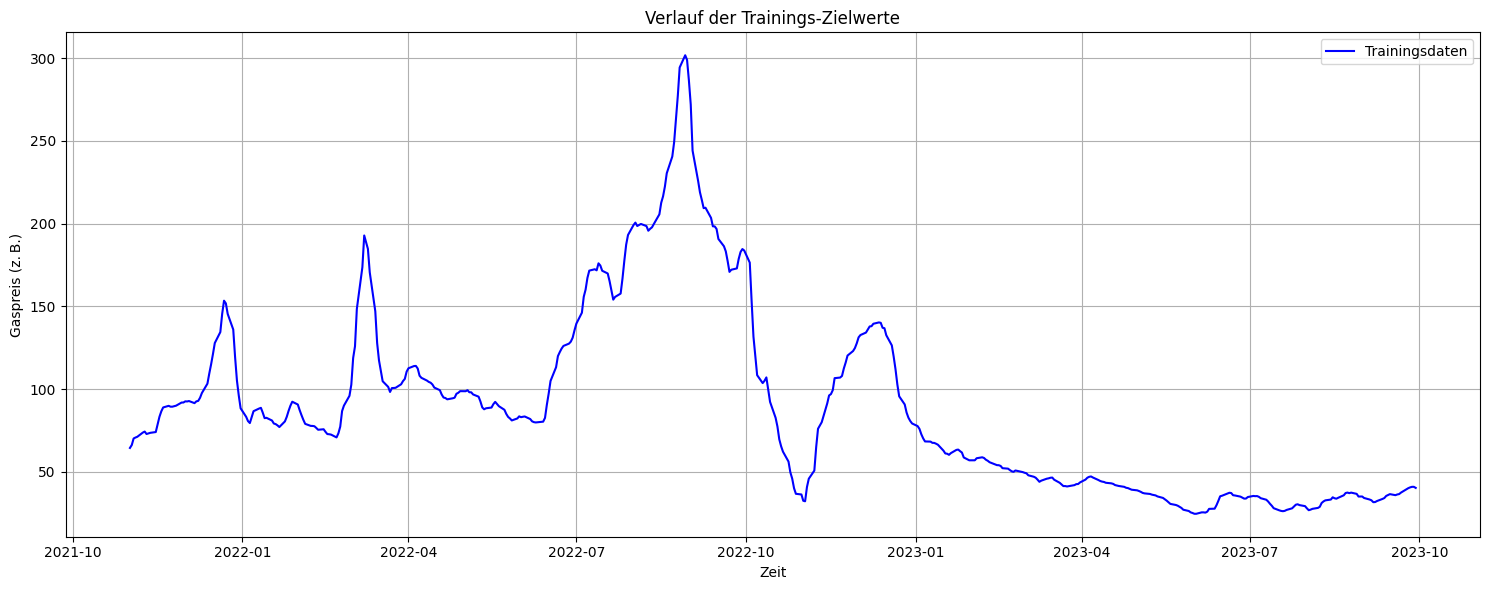

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(train_y_final.index, train_y_final.values, label='Trainingsdaten', color='blue')
plt.title('Verlauf der Trainings-Zielwerte')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis (z. B.)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Engineering

### Feature Extraction

#### Seasonality testing 

In [17]:
list_yearly_seasonality = [col for col in ['S-Coal Price (close)', 'A-Importiertes Erdgas Deutschland', 'N&P-Geschaeftsklima (Deutschland)', 'P-European_News_Index', 'P-GPR', 'A-Gas storage Full (%)', 'K-Temperatur 2m', 'N-Demand non-LDZ', 'N-Demand LDZ', 'S-Gas DA D', 'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Power price'] if col in train_final_df.columns]
list_monthly_seasonality = [col for col in ['N-Demand non-LDZ', 'N-Demand LDZ'] if col in train_final_df.columns]
list_weekly_seasonality = [col for col in ['S-Power price'] if col in train_final_df.columns]

#ACF 
"""for spalte in list_seasonality:
    plt.figure(figsize=(12, 6))
    plot_acf(train_final_df[spalte], lags=400, ax=plt.gca())  # lags anpassen
    plt.title(f'ACF - {spalte}')
    plt.xlabel('Lag')
    plt.ylabel('Autokorrelation')
    plt.show()"""

#STL aller Inputs
"""print (len(train_final_df))

for column in train_final_df.columns:
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12))

    # Linienplot der Variable
    train_final_df[column].plot(ax=axes[0])
    axes[0].set_title(f'Zeitverlauf - {column}')
    axes[0].set_ylabel(column)

    # ACF-Plot
    max_lags = len(train_final_df[column]) - 1
    plot_acf(train_final_df[column], lags=min(380, max_lags), ax=axes[1])
    axes[1].set_title(f'Autokorrelation - {column}')

    # Saisonale Dekomposition mit seasonal_decompose
    try:
        # Annahme: Periodizität von 170 (kann angepasst werden)
        decomposition = seasonal_decompose(train_final_df[column], period=2, model='additive', extrapolate_trend='freq')
        # decomposition.observed.plot(ax=axes[2]) # Original wird bereits geplottet
        # axes[2].set_title(f'Original (Decompose) - {column}')
        decomposition.trend.plot(ax=axes[2])
        axes[2].set_title(f'Trend (additiv) - {column}')
        decomposition.seasonal.plot(ax=axes[3])
        axes[3].set_title(f'Saisonalität (additiv) - {column}')
        decomposition.resid.plot(ax=axes[4])
        axes[4].set_title(f'Residuen (additiv) - {column}')

    except Exception as e:
        print(f"Saisonale Dekomposition für {column} fehlgeschlagen: {e}")

    plt.tight_layout()
    plt.show()"""
#ACF für alle Input Variablen
"""final_df_march_2022 = train_final_df.loc['2022-03-01':]
variables = train_final_df.columns
num_vars = len(variables)

cols = 3
rows = int(np.ceil(num_vars / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))

if num_vars == 1:
    axes = [axes]

for i, var in enumerate(variables):
    ax = axes[i // cols, i % cols]
    plot_acf(final_df_march_2022[var].dropna(), ax=ax, lags=600)
    ax.set_title(f"ACF für {var}")

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()"""


#Jede Spalte im DataFrame plotten
"""def plot_all_columns(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))  # Erstellt eine neue Figur für jede Spalte
        plt.plot(df[column])
        plt.title(f"Plot für {column}")
        plt.xlabel("Index")
        plt.ylabel("Wert")
        plt.show()
plot_all_columns(train_final_df)"""

# Plot y_final
"""y_final_2023 = y_final.loc['2023-01-01':]

y_final_2023.plot(figsize=(12, 6))
plt.title('Plot von y_final')
plt.xlabel('Datum')
plt.ylabel('Wert')
plt.grid(True)
plt.show()"""



"y_final_2023 = y_final.loc['2023-01-01':]\n\ny_final_2023.plot(figsize=(12, 6))\nplt.title('Plot von y_final')\nplt.xlabel('Datum')\nplt.ylabel('Wert')\nplt.grid(True)\nplt.show()"

#### Lag features oder (rolling) window
Beeded to convert time-series into Machine Learning problem
- test with ACF and PACF to determine the number of legs 
- might be useful to determine lags first and differentiate afterwards since teh models do not need stationarity

## Feature Extraction Time Series

In [18]:
import pandas as pd
from collections import defaultdict

# ---- 1. Konfiguration ----

# Manuell definierte saisonale Features
features_seasonality = [
    'K-Wind speed', 'N-Demand', 'N&P-Geschaeftsklima', 'S-Power price'
]

# Gruppenzuweisung nach Präfix
group_map = {
    "S-": "price",
    "K-": "climate",
    "A-": "storage",
    "N-": "demand",
    "P-": "policy",
    "N&P": "policy"  # Spezialfall für zusammengesetzte Bezeichner
}

# Erweiterte saisonale Lags (falls noch nicht vorhanden)
list_yearly_seasonality = [
    col for col in [
        'S-Coal Price (close)', 'A-Importiertes Erdgas Deutschland',
        'N&P-Geschaeftsklima (Deutschland)', 'P-European_News_Index', 'P-GPR',
        'A-Gas storage Full (%)', 'K-Temperatur 2m',
        'N-Demand non-LDZ', 'N-Demand LDZ', 'S-Gas DA D',
        'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Power price'
    ] if col in train_final_df.columns
]

list_monthly_seasonality = [
    col for col in ['N-Demand non-LDZ', 'N-Demand LDZ'] if col in train_final_df.columns
]

list_weekly_seasonality = [
    col for col in ['S-Gas DA D', 'S-Power price'] if col in train_final_df.columns
]

# ---- 2. Gruppierung der Spalten nach Präfix ----
grouped_features = defaultdict(list)

for col in train_final_df.columns:
    assigned = False
    for prefix, group in group_map.items():
        if col.startswith(prefix):
            grouped_features[group].append(col)
            assigned = True
            break
    if not assigned:
        grouped_features["other"].append(col)

# ---- 3. Feature-Ableitung nach Gruppenzugehörigkeit ----
all_features = []

for group, var_list in grouped_features.items():
    for col in var_list:
        base = train_final_df[col]
        out = pd.DataFrame(index=train_final_df.index)

        # Alle kriegen lag1
        out[f"{col}_lag1"] = base.shift(1)


        if group == "price":
            out[f"{col}_lag7"] = base.shift(7)
            out[f"{col}_rollmean_3"] = base.rolling(3, min_periods=1).mean()
            out[f"{col}_rollmean_7"] = base.rolling(7, min_periods=1).mean()
            out[f"{col}_rollstd_3"] = base.rolling(3, min_periods=1).std()
            out[f"{col}_rollmax_7"] = base.rolling(7, min_periods=1).max()

        elif group == "climate":
            out[f"{col}_lag7"] = base.shift(7)
            out[f"{col}_rollmean_7"] = base.rolling(7, min_periods=1).mean()
            out[f"{col}_rollmean_30"] = base.rolling(30, min_periods=1).mean()
            out[f"{col}_rollstd_7"] = base.rolling(7, min_periods=1).std()
            out[f"{col}_rollmin_7"] = base.rolling(7, min_periods=1).min()
            out[f"{col}_rollmax_7"] = base.rolling(7, min_periods=1).max()

        elif group == "demand":
            out[f"{col}_lag7"] = base.shift(7)
          #  out[f"{col}_lag365"] = base.shift(365)
            out[f"{col}_rollmean_30"] = base.rolling(30, min_periods=1).mean()
            out[f"{col}_rollstd_30"] = base.rolling(30, min_periods=1).std()

        elif group == "storage":
            out[f"{col}_rollmean_7"] = base.rolling(7, min_periods=1).mean()
            out[f"{col}_rollmin_7"] = base.rolling(7, min_periods=1).min()

        elif group == "policy":
            out[f"{col}_rollmean_30"] = base.rolling(30, min_periods=1).mean()

        all_features.append(out)

# ---- 4. DataFrame zusammenführen ----
features_df = pd.concat(all_features, axis=1)
train_final_df = pd.concat([train_final_df, features_df], axis=1)

# ---- 5. Zusätzliche saisonale Lags, falls noch nicht vorhanden ----

for col in list_monthly_seasonality:
    lag_col = f"{col}_lag30"
    if lag_col not in train_final_df.columns:
        train_final_df[lag_col] = train_final_df[col].shift(30)

for col in list_weekly_seasonality:
    lag_col = f"{col}_lag7"
    if lag_col not in train_final_df.columns:
        train_final_df[lag_col] = train_final_df[col].shift(7)

# ---- 6. NaN-Behandlung & Finalisierung ----
train_final_df = train_final_df.interpolate().bfill().ffill().astype('float32')

"""# Beispielhafte Interaktionskonstruktionen:
train_final_df["Gas_Dx_LDZmean30"] = (
    train_final_df["S-Gas DA D"] * train_final_df["N-Demand LDZ_rollmean_30"]
)

train_final_df["GasLag1_x_Wind7"] = (
    train_final_df["S-Gas DA D_lag1"] * train_final_df["K-Wind speed_rollmean_7"]
)

train_final_df["CoalStd_x_TempMin"] = (
    train_final_df["S-Coal Price (close)_rollstd_3"] * train_final_df["K-Wind speed_rollmin_7"]
)

train_final_df["NonLDZ_vs_LDZ"] = (
    train_final_df["N-Demand non-LDZ_lag30"] / train_final_df["N-Demand LDZ_rollmean_30"]
)

train_final_df["News30_x_Gas"] = (
    train_final_df["P-European_News_Index_rollmean_30"] * train_final_df["S-Gas DA D"]
)

train_final_df["Gas_diff_lag1"] = (
    train_final_df["S-Gas DA D"] - train_final_df["S-Gas DA D_lag1"]
)

train_final_df["LDZ_std_ratio"] = (
    train_final_df["N-Demand LDZ_rollstd_30"] / train_final_df["N-Demand LDZ_rollmean_30"]
)"""




'# Beispielhafte Interaktionskonstruktionen:\ntrain_final_df["Gas_Dx_LDZmean30"] = (\n    train_final_df["S-Gas DA D"] * train_final_df["N-Demand LDZ_rollmean_30"]\n)\n\ntrain_final_df["GasLag1_x_Wind7"] = (\n    train_final_df["S-Gas DA D_lag1"] * train_final_df["K-Wind speed_rollmean_7"]\n)\n\ntrain_final_df["CoalStd_x_TempMin"] = (\n    train_final_df["S-Coal Price (close)_rollstd_3"] * train_final_df["K-Wind speed_rollmin_7"]\n)\n\ntrain_final_df["NonLDZ_vs_LDZ"] = (\n    train_final_df["N-Demand non-LDZ_lag30"] / train_final_df["N-Demand LDZ_rollmean_30"]\n)\n\ntrain_final_df["News30_x_Gas"] = (\n    train_final_df["P-European_News_Index_rollmean_30"] * train_final_df["S-Gas DA D"]\n)\n\ntrain_final_df["Gas_diff_lag1"] = (\n    train_final_df["S-Gas DA D"] - train_final_df["S-Gas DA D_lag1"]\n)\n\ntrain_final_df["LDZ_std_ratio"] = (\n    train_final_df["N-Demand LDZ_rollstd_30"] / train_final_df["N-Demand LDZ_rollmean_30"]\n)'

## Scaling

In [19]:
# MinMaxScaler initialisieren
min_max_scaler = MinMaxScaler()

# Auswahl der numerischen Spalten (alle Spalten außer dem Datumsindex)
numerical_columns = train_final_df.select_dtypes(include=['float32']).columns
print (numerical_columns)
# Fit und Transform der numerischen Daten
scaled_data = min_max_scaler.fit_transform(train_final_df[numerical_columns])

# DataFrame mit den skalierten Daten und dem originalen Datumsindex
scaled_train_final_df = pd.DataFrame(scaled_data, columns=numerical_columns, index=train_final_df.index)

joblib.dump(min_max_scaler, 'min_max_scaler.pkl')

# Das skalierte DataFrame anzeigen
print(scaled_train_final_df.head())

y_min_max_scaler = MinMaxScaler()
train_y_final = train_y_final.astype('float32')
numerical_columns=train_y_final.select_dtypes(include=['float32']).columns
print (numerical_columns)
# Fit und Transform der numerischen Daten
scaled_data = y_min_max_scaler.fit_transform(train_y_final[numerical_columns])

# DataFrame mit den skalierten Daten und dem originalen Datumsindex
scaled_y_final_df = pd.DataFrame(scaled_data, columns=numerical_columns, index=train_y_final.index)
unscaled_train_final_df = train_final_df.copy()
unscaled_train_y_final = train_y_final.copy()
train_final_df = scaled_train_final_df
train_y_final = scaled_y_final_df

joblib.dump(y_min_max_scaler, 'y_min_max_scaler.pkl')

Index(['S-Coal Price (close)', 'K-Wind speed', 'S-Power price',
       'A-Flow Continental LNG Sendout ', 'A-Importiertes Erdgas Deutschland',
       'N&P-Geschaeftsklima (Deutschland)', 'P-European_News_Index', 'P-GPR',
       'A-Gas storage Full (%)', 'K-Temperatur 2m', 'N-Demand non-LDZ',
       'N-Demand LDZ', 'P-Schluss DXY ', 'P-EXY Average ', 'S-Gas DA D',
       'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Coal Price (close)_lag1',
       'S-Coal Price (close)_lag7', 'S-Coal Price (close)_rollmean_3',
       'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3',
       'S-Coal Price (close)_rollmax_7', 'S-Power price_lag1',
       'S-Power price_lag7', 'S-Power price_rollmean_3',
       'S-Power price_rollmean_7', 'S-Power price_rollstd_3',
       'S-Power price_rollmax_7', 'S-Gas DA D_lag1', 'S-Gas DA D_lag7',
       'S-Gas DA D_rollmean_3', 'S-Gas DA D_rollmean_7',
       'S-Gas DA D_rollstd_3', 'S-Gas DA D_rollmax_7',
       'S-Oil Spot Price (Brent)_lag1', 'S

['y_min_max_scaler.pkl']

In [20]:
print("Scaler min:", y_min_max_scaler.data_min_)
print("Scaler max:", y_min_max_scaler.data_max_)

Scaler min: [24.583]
Scaler max: [301.84]


#### Cyclic Features


In [21]:
# Add cyclic dummies

train_final_df['Month'] = train_final_df.index.month_name()
train_final_df['Season'] = train_final_df['Month'].apply(lambda m: 'Summer' if m in ['May', 'June', 'July', 'August', 'Septembre'] else 'Winter')
# One-Hot-Encoding für Saison und Monat, benannt als Saison_Sommer, Saison_Winter und Monat_1 bis Monat_12
train_final_df = pd.get_dummies(train_final_df, columns=['Season'], drop_first=False, dtype= int)
train_final_df = train_final_df.drop(columns=['Month'], axis=1)  # Monatsspalte entfernen, da sie nicht mehr benötigt wird
train_df = train_final_df
train_df = train_df.bfill()
train_y_df = train_y_final


with open('train_df.pkl', 'wb') as f:
    pickle.dump(train_df, f)
with open('train_y_df.pkl', 'wb') as f:
    pickle.dump(train_y_df, f)







In [22]:

unscaled_train_final_df['Month'] = unscaled_train_final_df.index.month_name()
unscaled_train_final_df['Season'] = unscaled_train_final_df['Month'].apply(lambda m: 'Summer' if m in ['May', 'June', 'July', 'August', 'Septembre'] else 'Winter')
# One-Hot-Encoding für Saison und Monat, benannt als Saison_Sommer, Saison_Winter und Monat_1 bis Monat_12
unscaled_train_final_df = pd.get_dummies(unscaled_train_final_df, columns=['Season'], drop_first=False, dtype= int)
unscaled_train_final_df = unscaled_train_final_df.drop(columns=['Month'], axis=1)  # Monatsspalte entfernen, da sie nicht mehr benötigt wird
unscaled_train_final_df = unscaled_train_final_df.bfill()



with open('unscaled_train_final_df.pkl', 'wb') as f:
    pickle.dump(unscaled_train_final_df, f)
with open('unscaled_train_y_df.pkl', 'wb') as f:
    pickle.dump(unscaled_train_y_final, f)